MNIST GAN
---------

In this example, we will train a Generative Adversarial Network (GAN) on the MNIST dataset.  This is a large collection of 28x28 pixel images of handwritten digits.  We will try to train a network to produce new images of handwritten digits.

To begin, let's import all the libraries we'll need and load the dataset (which comes bundled with Tensorflow).

In [2]:
import deepchem as dc
import tensorflow as tf
from deepchem.models.tensorgraph.optimizers import ExponentialDecay
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
images = mnist.train.images.reshape((-1, 28, 28, 1))
dataset = dc.data.NumpyDataset(images)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Let's view some of the images to get an idea of what they look like.

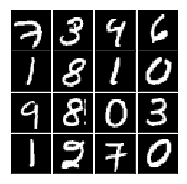

In [3]:
def plot_digits(im):
  plot.figure(figsize=(3, 3))
  grid = gridspec.GridSpec(4, 4, wspace=0.05, hspace=0.05)
  for i, g in enumerate(grid):
    ax = plot.subplot(g)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im[i,:,:,0], cmap='gray')

plot_digits(images)

Now we can create our GAN.  It consists of two parts:

1. The generator takes random noise as its input and produces output that will hopefully resemble the training data.
2. The discriminator takes a set of samples as input (possibly training data, possibly created by the generator), and tries to determine which are which.  Its output is interpreted as a measure of how likely it is that each sample is from the training set.

In [5]:
class DigitGAN(dc.models.WGAN):

  def get_noise_input_shape(self):
    return (10,)

  def get_data_input_shapes(self):
    return [(28, 28, 1)]

  def create_generator(self):
    return tf.keras.Sequential([
        Dense(7*7*8, activation=tf.nn.relu),
        Reshape((7, 7, 8)),
        Conv2DTranspose(filters=16, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same'),
        Conv2DTranspose(filters=1, kernel_size=5, strides=2, activation=tf.sigmoid, padding='same')
    ])

  def create_discriminator(self):
    return tf.keras.Sequential([
        Conv2D(filters=32, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Conv2D(filters=64, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Dense(1, activation=tf.math.softplus)
    ])

gan = DigitGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))

Now to train it.  The generator and discriminator are both trained together.  The generator tries to get better at fooling the discriminator, while the discriminator tries to get better at distinguishing real data from generated data (which in turn gives the generator a better training signal to learn from).

In [7]:
def iterbatches(epochs):
  for i in range(epochs):
    for batch in dataset.iterbatches(batch_size=gan.batch_size):
      yield {gan.data_inputs[0]: batch[0]}

gan.fit_gan(iterbatches(100), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 6508: generator average loss 0.478968, discriminator average loss 0.47897
Ending global_step 11508: generator average loss 0.526329, discriminator average loss 0.52613
Ending global_step 16508: generator average loss 0.61444, discriminator average loss 0.614101
Ending global_step 21508: generator average loss 0.591739, discriminator average loss 0.591466
Ending global_step 26508: generator average loss 0.56283, discriminator average loss 0.562656
Ending global_step 31508: generator average loss 0.538769, discriminator average loss 0.538729
Ending global_step 36508: generator average loss 0.536539, discriminator average loss 0.53636
Ending global_step 41508: generator average loss 0.53402, discriminator average loss 0.533926
Ending global_step 46508: generator average loss 0.536422, discriminator average loss 0.536265
Ending global_step 51508: generator average loss 0.530185, discriminator average loss 0.530161
Ending global_step 56508: generator average loss 0.506654

Let's generate some data and see how the results look.

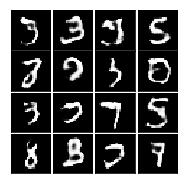

In [9]:
plot_digits(gan.predict_gan_generator(batch_size=16))

Not too bad.  Many of the generated images look plausibly like handwritten digits.  A larger model trained for a longer time can do much better, of course.